In [1]:
from pyironflow.pyironflow import PyironFlow
import matplotlib.pyplot as plt
from pyiron_nodes.atomistic.mlips.fitting.ace import *  # Re-import everything


# Prelude:

## Loading Dataset:

Firstly, we load the dataset by providing the `file_path`

In [2]:
load_dataset = ReadPickledDatasetAsDataframe(file_path = "data/mgca.pckl.tgz", compression = None)
load_dataset.pull();

Using the `PlotEnergyHistogram` Node, we can plot the energy histogram

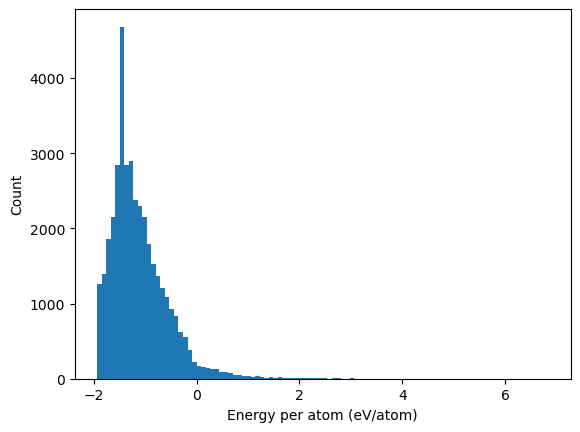

In [3]:
hist_plot = PlotEnergyHistogram(df = load_dataset.outputs.df, log_scale = False)
hist_plot.pull();

Similarly, using the `PlotForcesHistogram` Node, we can plot the forces histogram

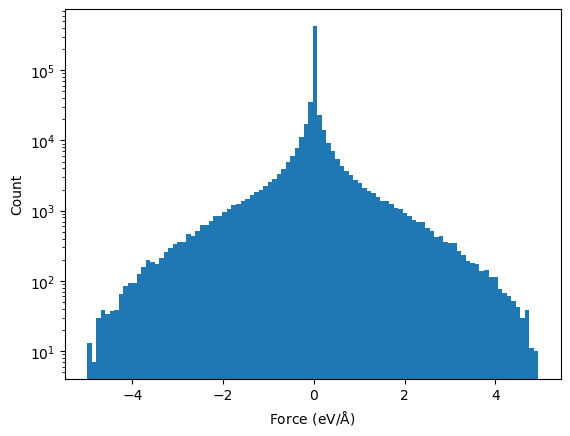

In [4]:
hist_plot = PlotForcesHistogram(df = load_dataset.outputs.df, log_scale = True)
hist_plot.pull();

## Split Dataset into Training and Testing Datasets:

Secondly, we split the dataset into training and testing datasets.

This is done by choosing the percentage used for training dataset through the `training_frac` parameter where `training_frac = 0.5` means we are using 50% for training and 50% for testing.

In [5]:
split_dataset = SplitTrainingAndTesting(data_df = load_dataset.outputs.df, training_frac = 0.5)

## Construct Potential Config:

Similarly as in `PACEmaker`, we want to have a file which is similar to `input.yaml` file that looks like that,

```
fit:
  fit_cycles: 1
  loss: {L1_coeffs: 1e-08, L2_coeffs: 1e-08, kappa: 0.08, w0_rad: 0, w1_rad: 0, w2_rad: 0}
  maxiter: 1000
  optimizer: BFGS
  trainable_parameters: ALL
  weighting: {DE: 1.0, DElow: 1.0, DEup: 10.0, DF: 1.0, DFup: 50.0, energy: convex_hull,
    nfit: 20000, reftype: all, seed: 42, type: EnergyBasedWeightingPolicy, wlow: 0.95}
.
.
.
potential:
  bonds:
    ALL:
      dcut: 0.01
      radbase: SBessel
      radparameters: [5.25]
      rcut: 6.0
  elements: [Mg, Ca]
  embeddings:
    ALL:
      fs_parameters: [1, 1, 1, 0.5]
      ndensity: 2
      npot: FinnisSinclairShiftedScaled
  functions:
    number_of_functions_per_element = 300
    ALL:
      lmax_by_orders: [15, 6, 2, 1]
      nradmax_by_orders: [0, 6, 3, 1]

For simplicity, the main inputs that we will consider for the potential configurations are,

- `number_of_functions_per_element`: specifies how many functions will be provided in the potential
- `rcut`: specifies what the cutoff radius is

In [6]:
parameterize_potential = ParameterizePotentialConfig(number_of_functions = 10, rcut = 6.0)

Check the current potential configurations in dictionary format,

In [7]:
parameterize_potential.pull().to_dict()

{'deltaSplineBins': 0.001,
 'embeddings': {'ALL': {'npot': 'FinnisSinclairShiftedScaled',
   'fs_parameters': [1, 1],
   'ndensity': 1}},
 'bonds': {'ALL': {'radbase': 'SBessel',
   'radparameters': [5.25],
   'rcut': 6.0,
   'dcut': 0.01}},
 'functions': {'number_of_functions_per_element': 10,
  'ALL': {'nradmax_by_orders': [15, 3, 2, 1], 'lmax_by_orders': [0, 3, 2, 1]}}}

## Linear Fitting:

Finally, we run our fit with the `potential_config` we obtained and then save the potential files inside a new folder.

**Note:** Setting `verbose = True` will show all the details of building the design matrices.

In [8]:
run_linear_fit = RunLinearFit(potential_config = parameterize_potential,
                                                df_train = split_dataset.outputs.df_training,
                                                df_test= split_dataset.outputs.df_testing, verbose = False)

In [9]:
save_potential = SavePotential(basis = run_linear_fit.outputs.basis)

In [10]:
save_potential.pull()

Design Matrix of Training dataset has been constructed!
Design Matrix of Testing dataset has been constructed!
Fitting Done in 5.3 seconds.
====================== TRAINING INFO ======================
Training E RMSE: 160.54 meV/atom
Training F RMSE: 105.63 meV/A
======================= TESTING INFO =======================
Testing E RMSE: 158.99 meV/atom
Testing F RMSE: 109.50 meV/A
Potentials "Ca_Mg_linear_potential.yaml" and "Ca_Mg_linear_potential.yace" are saved in "/home/poul/pyiron/DPG-tutorial-2025/potentials".


(<pyace.basis.ACEBBasisSet at 0x7fe169d72db0>,
 '/home/poul/pyiron/DPG-tutorial-2025/potentials/Ca_Mg_linear_potential.yace')

# Workflow:

In [11]:
wf = make_linearfit(workflow_name= 'LinearAceDataset', file_path='data/mgca.pckl.tgz', delete_existing_savefiles=True)

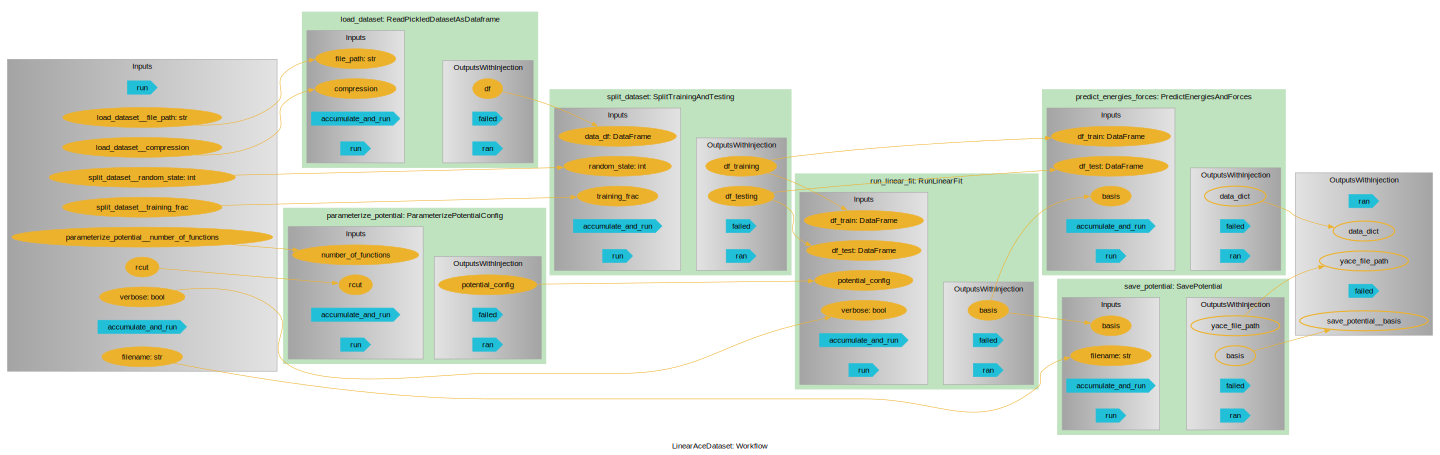

In [12]:
wf.draw(size=(20,10))

In [13]:
output = wf.run()

Design Matrix of Training dataset has been constructed!
Design Matrix of Testing dataset has been constructed!
Fitting Done in 4.9 seconds.
====================== TRAINING INFO ======================
Training E RMSE: 160.54 meV/atom
Training F RMSE: 105.63 meV/A
======================= TESTING INFO =======================
Testing E RMSE: 158.99 meV/atom
Testing F RMSE: 109.50 meV/A


Predicting Energies and Forces of Training dataset:   0%|          | 0/19340 [00:00<?, ?it/s]

Predicting Energies and Forces of Testing dataset:   0%|          | 0/19341 [00:00<?, ?it/s]

Potentials "Ca_Mg_linear_potential.yaml" and "Ca_Mg_linear_potential.yace" are saved in "/home/poul/pyiron/DPG-tutorial-2025/potentials".


You can save the workflow using `wf.save()` to call it back later without the need to re-run it.

In [14]:
wf.save()

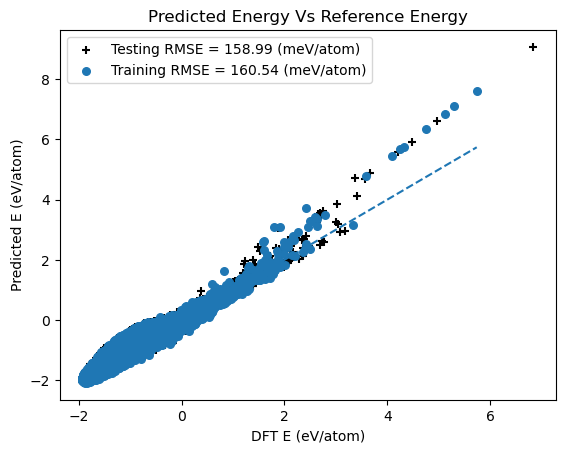

In [15]:
fitting_plot = PlotEnergyFittingCurve(output['data_dict'])
fitting_plot.pull();

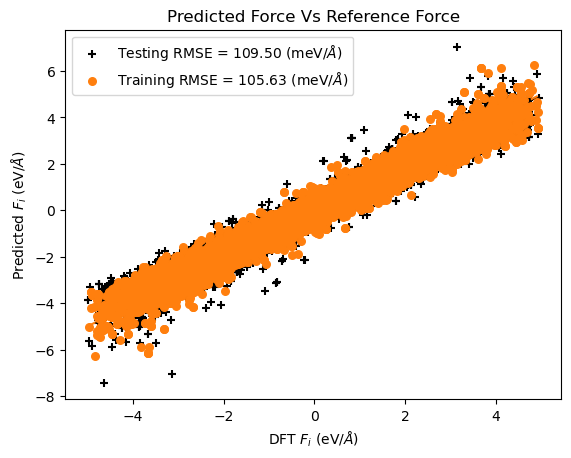

In [16]:
fitting_plot = PlotForcesFittingCurve(output['data_dict'])
fitting_plot.pull();

# Loading Workflow in GUI:

Using the GUI, change the `number_of_functions_per_element` to a higher value (i.e., 50) and check the fitting curves. Did the fit get better or worse?

**NOTE:** You can change the ratio of the canvas to the whole screen by changing the value of `flow_widget_ratio` between 0 to 1 (try 0.6 or 0.7)

In [17]:
pf = PyironFlow([wf], flow_widget_ratio = 0.7)
pf.gui